# **Week 3 - Statistical Arbitrage**

In [1]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from itertools import combinations

In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('petroff10')
plt.rcParams['figure.facecolor'] = 'white'

## **What is Pairs Trading?**

**Pairs trading** is a specific subset of **statistical arbitrage**, a broader category of quantitative trading strategies that exploit statistical mispricings in financial markets. While the two terms are sometimes used interchangeably, pairs trading focuses on the relative mispricing between two (or more) co-moving assets.

In its simplest form, pairs trading involves identifying two assets that historically move together and establishing long and short positions to profit from any temporary divergence in their prices. Specifically, you go long the underperforming asset and short the outperforming one, expecting that their price relationship will revert to its historical mean over time.

Developing a pairs trading strategy typically involves three key steps:

1. **Pairs Selection**: Identify suitable assets with a stable, historically observed relationship.
2. **Spread Modeling**: Model and test the spread (or linear combination) for stationarity or mean reversion.
3. **Trading Rules:** Define entry and exit criteria, position sizing, and risk management parameters.

For a deeper discussion on pairs trading, see this [article](https://hudsonthames.org/definitive-guide-to-pairs-trading/#taxonomy) by Hudson & Thames.


## **1. Pairs Selection**

In the pairs selection step, we aim to identify co-moving securities by utilizing methods like **distance metrics** and **cointegration tests**.

#### **Price Normalization**

Before modeling the spread between all possible combinations of stock pairs during the **train period** (which is chosen to be 12 months), we first normalize the price series to eliminate differences in absolute price levels.

The normalization ensures that stocks are compared based on their relative movements rather than raw price differences. The typical normalization formula for a stock $S_i$ at time $t$ is:

$$\tilde{P}_{i, t} = \frac{P_{i, t}}{P_{i, 1}}$$

By normalizing, all price series are scaled to $1 at the beginning of the period, allowing for a fair comparison of price movements.

In [5]:
# Download data for train period
url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
tickers = pd.read_html(url)[2]['Symbol'].tolist()
data = yf.download(tickers, start='2023-01-01', end='2023-12-31')['Close']
data

[*********************100%***********************]  30 of 30 completed


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,123.632523,243.500763,85.820000,142.924423,195.389999,229.551071,134.031387,44.742985,158.737137,87.884308,...,235.240005,115.257538,14.304595,143.352737,235.046280,179.657349,503.071106,203.852280,34.429852,46.589111
2023-01-04,124.907707,246.050781,85.139999,146.246887,203.639999,231.934189,138.814667,44.733574,157.049286,90.857582,...,224.949875,117.645187,14.738279,143.976944,239.769363,179.762955,489.355560,208.983215,35.296612,46.641022
2023-01-05,123.583099,248.349411,83.120003,142.747177,204.990005,230.896378,135.582703,44.103271,159.877563,90.798302,...,218.282883,117.072540,14.254633,142.189438,223.636169,180.070190,475.252014,207.508789,35.785770,46.482052
2023-01-06,128.130203,256.110870,86.080002,146.393112,213.000000,239.141296,139.729538,45.457973,161.081833,92.773903,...,220.855408,120.867538,14.848199,145.575333,231.540771,186.138123,475.290802,214.035538,36.206276,47.620823
2023-01-09,128.654144,251.383331,87.360001,146.617325,208.570007,236.988785,146.282944,45.702572,159.822784,93.613525,...,223.005707,121.178131,15.616641,143.797241,231.746979,181.577576,475.348999,214.871048,36.060707,47.027103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.444580,273.615173,153.419998,182.944183,260.440002,284.732635,264.860657,48.182617,143.222794,90.202316,...,371.055664,106.217964,48.816162,140.891922,308.683197,182.480545,512.289124,256.038818,34.535919,51.598206
2023-12-26,191.897873,273.364807,153.410004,183.328659,262.790009,289.900543,264.741302,48.365379,144.512314,90.132942,...,371.134979,106.198288,49.265030,141.531998,310.071564,183.747513,512.013550,256.762024,34.526711,51.519150
2023-12-27,191.997269,275.897247,153.339996,184.413086,262.100006,292.342255,265.238556,48.519287,144.038223,89.568062,...,370.550507,105.323311,49.402988,141.648376,310.666565,185.250168,514.730957,256.534180,34.370106,52.003345


In [6]:
# Normalize price series
data_normalized = data / data.iloc[0]

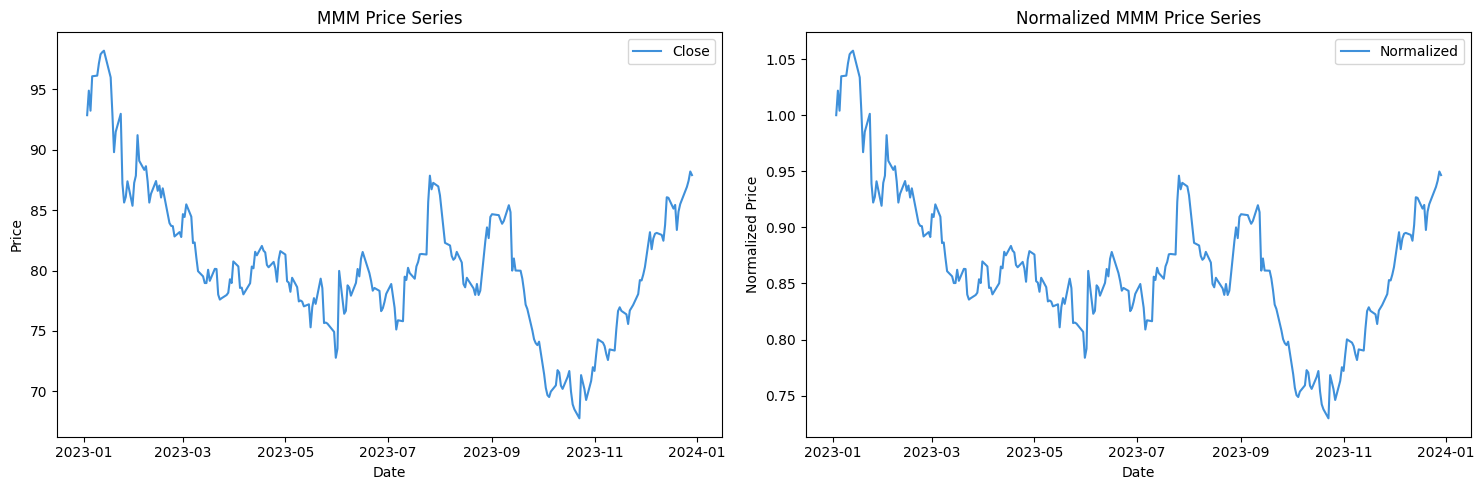

In [7]:
# Compare close vs. normalized prices
ticker = tickers[0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(data.index, data[ticker], label='Close')
ax[0].set_title(f'{ticker} Price Series')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[0].legend()

ax[1].plot(data_normalized.index, data_normalized[ticker], label='Normalized')
ax[1].set_title(f'Normalized {ticker} Price Series')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Normalized Price')
ax[1].legend()

plt.tight_layout()
plt.show()

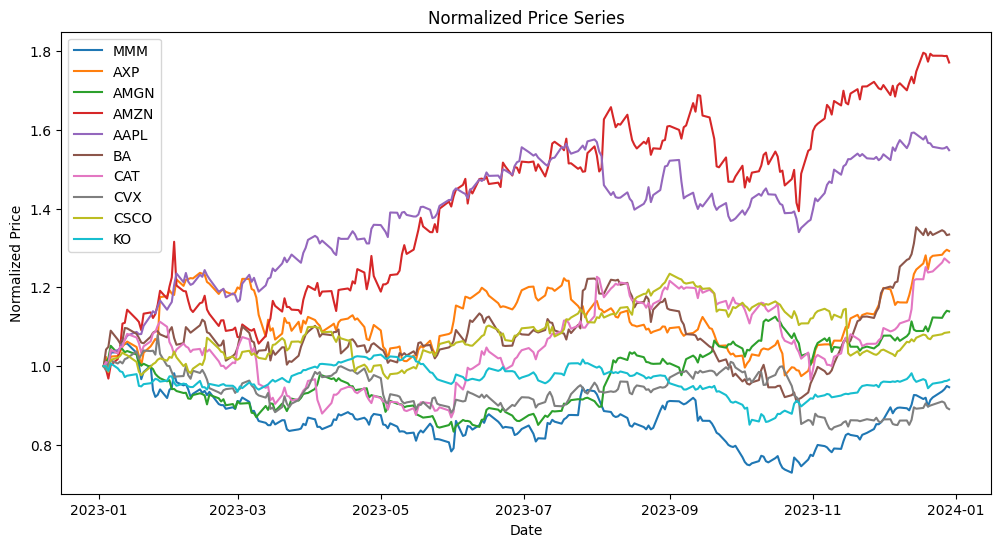

In [8]:
# Visualize normalized price series
plt.figure(figsize=(12, 6))

cmap = plt.cm.get_cmap('tab10', 10)
for i, ticker in enumerate(tickers[:10]):
  color = cmap(i / 10)
  plt.plot(data_normalized.index, data_normalized[ticker], label=ticker, color=color)

plt.title('Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

#### **Distance Approach**

After the prices have been normalized, we use the **distance approach** to select pairs of stocks based on how closely their price movements track each other. This approach ranks potential pairs by computing the **sum of squared differences (SSD)** between their normalized price series over the formation period.

For a pair of stocks $(S_i, S_j)$, SSD is computed as:

$$SSD(i, j) = \sum_{t=1}^{T} (\tilde{P}_{i,t} - \tilde{P}_{j,t})^2$$

A lower SSD indicates that the two stocks have historically moved together more closely, making them better candidates for pairs trading.

Once SSD is computed for all possible pairs, stocks are ranked in ascending order based on SSD values. The top-ranked pairs are chosen for further analysis, such as the **cointegration test** to ensure mean-reverting behavior.

In [9]:
# Compute pairwise sum of squared distances
pair_distances = {}
for (ticker_1, ticker_2) in combinations(tickers, 2):
    distance = ((data_normalized[ticker_1] - data_normalized[ticker_2]) ** 2).sum()
    pair_distances[(ticker_1, ticker_2)] = distance
    print(f'Distance between {ticker_1} and {ticker_2}: {distance:.2f}')

Distance between MMM and AXP: 17.18
Distance between MMM and AMGN: 5.55
Distance between MMM and AMZN: 90.48
Distance between MMM and AAPL: 74.79
Distance between MMM and BA: 13.55
Distance between MMM and CAT: 11.88
Distance between MMM and CVX: 2.24
Distance between MMM and CSCO: 14.11
Distance between MMM and KO: 3.18
Distance between MMM and DIS: 8.72
Distance between MMM and GS: 4.04
Distance between MMM and HD: 4.66
Distance between MMM and HON: 1.35
Distance between MMM and IBM: 7.93
Distance between MMM and JNJ: 1.23
Distance between MMM and JPM: 14.39
Distance between MMM and MCD: 11.51
Distance between MMM and MRK: 4.67
Distance between MMM and MSFT: 61.94
Distance between MMM and NKE: 3.10
Distance between MMM and NVDA: 866.10
Distance between MMM and PG: 5.72
Distance between MMM and CRM: 117.61
Distance between MMM and SHW: 11.82
Distance between MMM and TRV: 2.04
Distance between MMM and UNH: 4.69
Distance between MMM and VZ: 2.31
Distance between MMM and V: 20.23
Distanc

In [10]:
# Get top 20 pairs with smallest SSD
pair_distances_sorted = sorted(pair_distances.items(), key=lambda x: x[1])
for i, (pair, distance) in enumerate(pair_distances_sorted[:20]):
  print(f'{i + 1}. {pair[0]} and {pair[1]}: {distance:.2f}')

1. KO and MRK: 0.31
2. HON and TRV: 0.35
3. TRV and VZ: 0.40
4. HON and JNJ: 0.45
5. CSCO and WMT: 0.48
6. MRK and PG: 0.51
7. GS and HD: 0.54
8. CVX and JNJ: 0.64
9. KO and TRV: 0.69
10. NKE and VZ: 0.69
11. KO and PG: 0.71
12. JPM and SHW: 0.72
13. AMGN and UNH: 0.73
14. KO and HON: 0.81
15. HON and VZ: 0.83
16. PG and UNH: 0.84
17. GS and TRV: 0.90
18. CVX and HON: 0.93
19. JNJ and TRV: 0.98
20. KO and VZ: 0.99


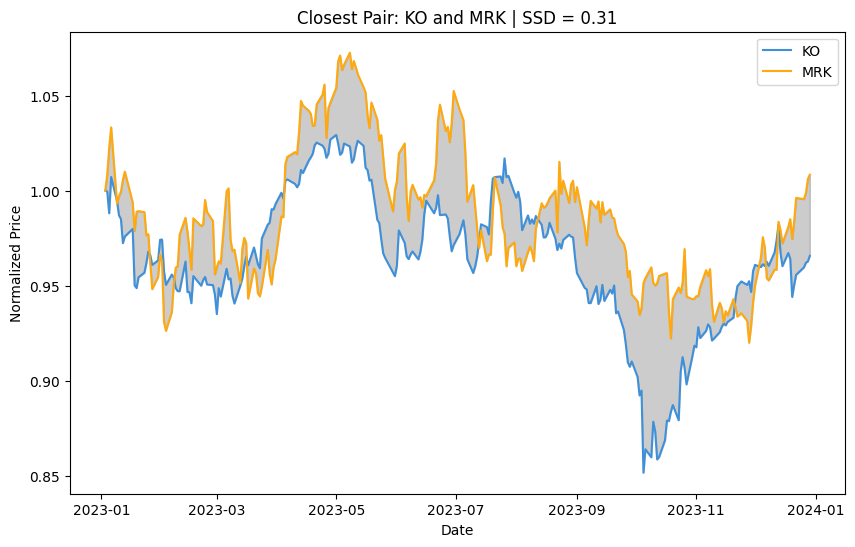

In [11]:
# Visualize price series for closest pair
ticker_1, ticker_2 = pair_distances_sorted[0][0]
min_distance = pair_distances_sorted[0][1]

plt.figure(figsize=(10, 6))
plt.plot(data_normalized.index, data_normalized[ticker_1], label=ticker_1)
plt.plot(data_normalized.index, data_normalized[ticker_2], label=ticker_2)
plt.fill_between(
    data_normalized.index,
    data_normalized[ticker_1],
    data_normalized[ticker_2],
    color='gray',
    alpha=0.4
)
plt.title(f'Closest Pair: {ticker_1} and {ticker_2} | SSD = {min_distance:.2f}')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

#### **Cointegration Method**

After sorting all possible combinations of pairs based on their SSD in their normalized price series, we test each pair with the least SSD for **cointegration**, which is a statistical concept used in time-series analysis that identifies a **long-term equilibrium relationship** between two or more non-stationary time series.

In the context of pairs trading, cointegration means that while two stock prices may individually follow a random walk, a specific **linear combination** of them remains **stationary** and fluctuates around a stable mean. This suggests that any deviation from equilibrium is temporary and the spread between them will eventually revert.  

Mathematically, if $X_t$ and $Y_t$ are non-stationary price series, they are cointegrated if there exists a non-zero constant $\beta$ such that:

$$Z_t = Y_t - \beta X_t$$

is stationary (it has a constant mean and variance over time).

In [12]:
# Perform cointegration test on stock pairs
coint_pairs = []

for (ticker_1, ticker_2) in dict(pair_distances_sorted).keys():
  # Engle-Granger two-step method
  results = coint(data[ticker_1], data[ticker_2])
  pvalue = results[1]
  if pvalue < 0.05:
    coint_pairs.append((ticker_1, ticker_2))
    print(f'P-value between {ticker_1} and {ticker_2}: {pvalue:.4f}')

  # Continue until 10 cointegrated pairs are selected
  if len(coint_pairs) == 10:
    break

P-value between TRV and VZ: 0.0344
P-value between JPM and SHW: 0.0071
P-value between AAPL and MSFT: 0.0423
P-value between DIS and NKE: 0.0194
P-value between IBM and V: 0.0255
P-value between DIS and WMT: 0.0290
P-value between CSCO and DIS: 0.0058
P-value between UNH and V: 0.0296
P-value between CSCO and VZ: 0.0432
P-value between CSCO and NKE: 0.0034


In [13]:
# Get best cointegrated pair with smallest SSD
best_pair = coint_pairs[0]
print(f'Best pair: {best_pair[0]} and {best_pair[1]}')

Best pair: TRV and VZ


## **2. Spread Modeling**

Once we identify the pair whose prices $(P_{1,t}, P_{2,t})$ are cointegrated and have the smallest SSD, we estimate the hedge ratio $\beta$ using **Ordinary Least Squares (OLS) regression**:

$$\beta = \frac{Cov(P_{1,t}, P_{2,t})}{Var(P_{2,t})}$$

This ratio determines the optimal proporation in which the stocks should be traded to construct a stationary spread:

$$Spread_t = P_{2,t} - \beta P_{1,t}$$

The spread will then be monitored and traded using one or more pre-defined rules.

In [14]:
# Function to run linear regression
def lin_reg(X, Y):
  X = sm.add_constant(X)
  model = sm.OLS(Y, X).fit()
  params = model.params
  return params

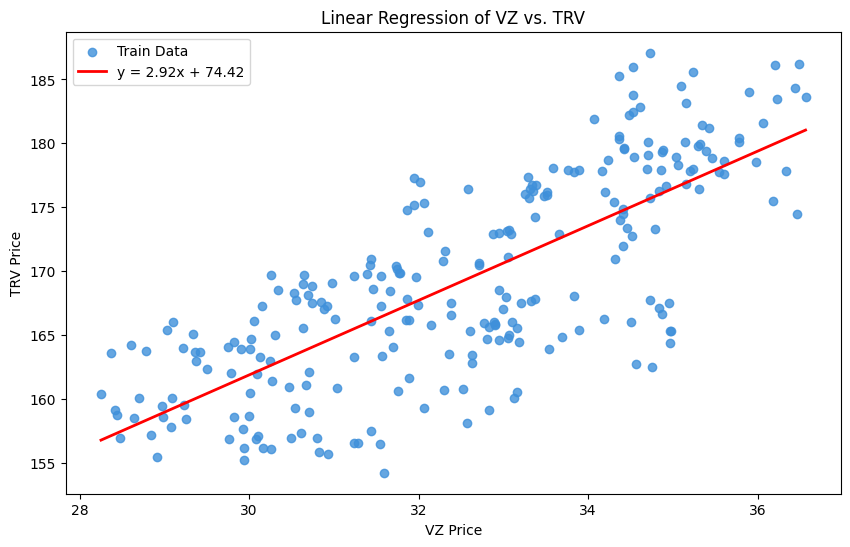

In [15]:
# Perform linear regression on best pair
ticker_1, ticker_2 = best_pair[::-1]
intercept, slope = lin_reg(data[ticker_1], data[ticker_2])
x_line = np.linspace(min(data[ticker_1]), max(data[ticker_1]), 100)
y_line = slope * x_line + intercept

plt.figure(figsize=(10, 6))
plt.scatter(data[ticker_1], data[ticker_2], label='Train Data', alpha=0.8)
plt.plot(x_line, y_line, label=f'y = {slope:.2f}x + {intercept:.2f}', color='red', linewidth=2)
plt.title(f'Linear Regression of {ticker_1} vs. {ticker_2}')
plt.xlabel(f'{ticker_1} Price')
plt.ylabel(f'{ticker_2} Price')
plt.legend()
plt.show()

In [16]:
# Compute train spread using hedge ratio
hedge_ratio = slope
train_spread = data[ticker_2] - hedge_ratio * data[ticker_1]
train_spread_mean = train_spread.mean()

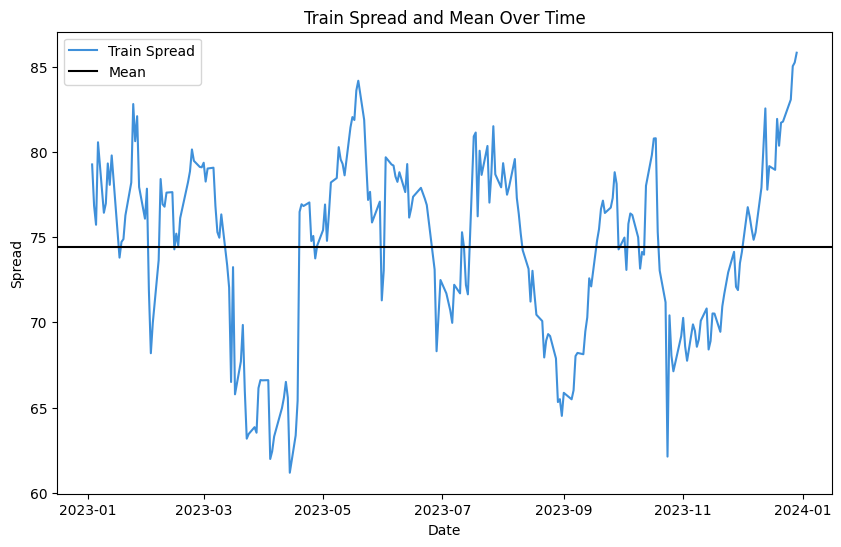

In [17]:
# Visualize train spread and its mean
plt.figure(figsize=(10, 6))
plt.plot(train_spread.index, train_spread, label='Train Spread')
plt.axhline(train_spread_mean, label='Mean', color='black')
plt.title('Train Spread and Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

So far, we have used data from the **train period** to both test for a stationary spread and compute the hedge ratio. However, using the spread computed from the train period to backtest our strategy introduces **look-ahead bias** because it relies on future stock prices to model the spread, which is an information that would not be available at the time of trading.

To mitigate this, we apply a **rolling hedge ratio** during a separate **test period** to dynamically model the spread. However, this approach relies on the assumption that *the cointegration relationship remains stable throughout the test period*, which may not always hold. In real-world trading, cointegration relationships can break down due to shifts in market conditions, fundamentals, or liquidity.

Therefore, when actually implementing a pairs trading strategy, it is advised to trade multiple pairs simultaneously rather than relying on a single pair. This **diversification** helps mitigate the impact of any individual pair failing to maintain its equilibrium relationship.

In [18]:
# Download data for test period
tickers = [ticker_1, ticker_2]
test_data = yf.download(tickers, start='2024-01-01', end='2024-12-31')['Close']
test_data

[*********************100%***********************]  2 of 2 completed


Ticker,TRV,VZ
Date,,
2024-01-02,188.000137,35.816391
2024-01-03,187.882324,36.074329
2024-01-04,189.100143,36.267784
2024-01-05,189.620682,37.032379
2024-01-08,188.874268,36.940262
...,...,...
2024-12-23,241.360001,39.244587
2024-12-24,242.880005,39.107025
2024-12-26,243.729996,39.264240


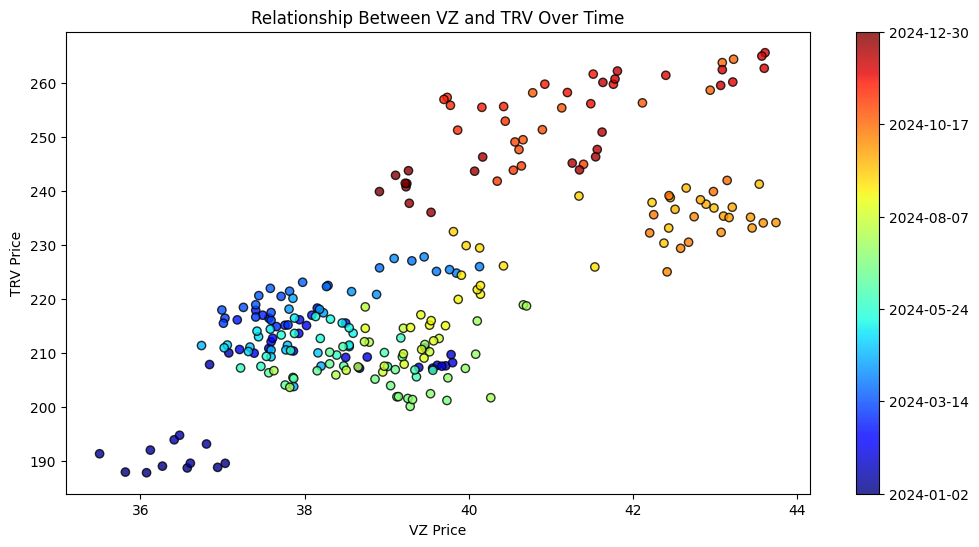

In [19]:
# Visualize price relationship over time
plt.figure(figsize=(12, 6))

colors = np.linspace(0, 1, len(test_data))
sc = plt.scatter(
    test_data[ticker_1],
    test_data[ticker_2],
    c=colors,
    cmap='jet',
    edgecolor='black',
    alpha=0.8
)

cb = plt.colorbar(sc)
num_ticks = 6
tick_positions = np.linspace(0, len(test_data) - 1, num_ticks).astype(int)
cb.set_ticks(np.linspace(0, 1, num_ticks))
cb.set_ticklabels(test_data.index[tick_positions].strftime('%Y-%m-%d'))

plt.title(f'Relationship Between {ticker_1} and {ticker_2} Over Time')
plt.xlabel(f'{ticker_1} Price')
plt.ylabel(f'{ticker_2} Price')
plt.show()

In [20]:
# Compute test spread using rolling hedge ratios
window = 30
rolling_hedge_ratios = pd.Series(index=test_data.index, dtype=float)
test_spread_mean = pd.Series(index=test_data.index, dtype=float)
test_spread_std = pd.Series(index=test_data.index, dtype=float)

for i in range(window, len(test_data) + 1):
  window_data_1 = test_data[ticker_1][i - window:i]
  window_data_2 = test_data[ticker_2][i - window:i]

  # Compute rolling hedge ratio
  hedge_ratio = lin_reg(window_data_1, window_data_2)[1]
  rolling_hedge_ratios.iloc[i - 1] = hedge_ratio

  # Compute windowed mean and standard deviation
  sample_spread = window_data_2 - hedge_ratio * window_data_1
  test_spread_mean.iloc[i - 1] = sample_spread.mean()
  test_spread_std.iloc[i - 1] = sample_spread.std()

test_spread = test_data[ticker_2] - rolling_hedge_ratios * test_data[ticker_1]

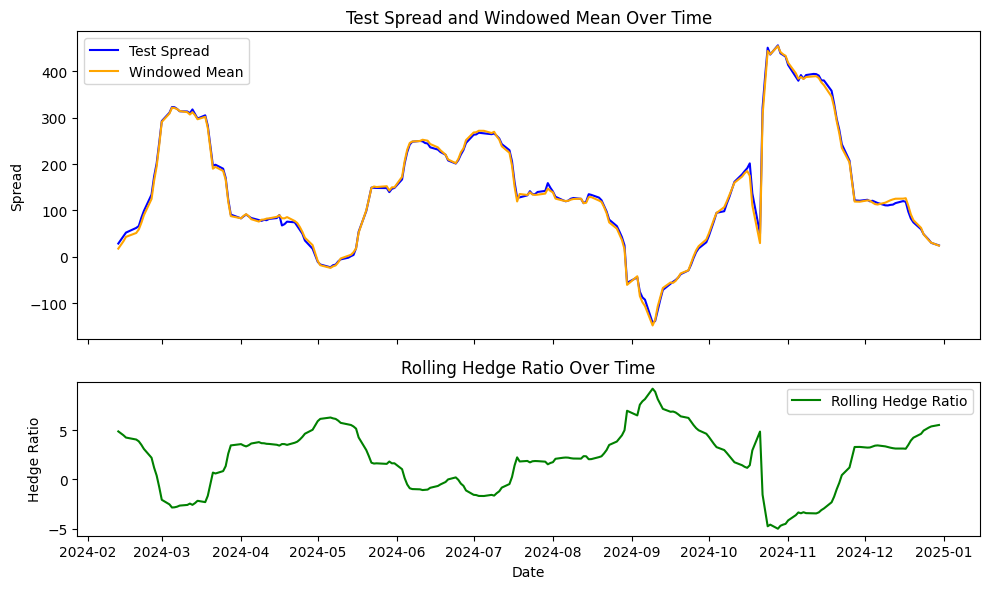

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot test spread and windowed mean
ax[0].plot(test_spread.index, test_spread, label='Test Spread', color='blue')
ax[0].plot(test_spread_mean.index, test_spread_mean, label='Windowed Mean', color='orange')
ax[0].set_title('Test Spread and Windowed Mean Over Time')
ax[0].set_ylabel('Spread')
ax[0].legend()

# Plot rolling hedge ratio
ax[1].plot(rolling_hedge_ratios.index, rolling_hedge_ratios, label='Rolling Hedge Ratio', color='green')
ax[1].set_title('Rolling Hedge Ratio Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Hedge Ratio')
ax[1].legend()

plt.tight_layout()
plt.show()

## **3. Trading Rules**

To define trading signals, we first compute the **z-score** of the spread:

$$Z_t = \frac{S_t - \mu_t}{\sigma_t}$$

where
* $S_t$ is the spread at time $t$.
* $\mu_t$ is the rolling mean of the spread.
* $\sigma_t$ is the rolling standard deviation of the spread.

Finally, the actual strategy follows a **mean-reverting** approach, entering trades when the spread deviates signficantly from its mean and exiting when it reverts:

1. Enter a long position (buy the spread) using the hedge ratio when $Z_t < -1$.
2. Enter a short position (sell the spread) using the hedge ratio when $Z_t > 1$.
3. Exit long position when $Z_t > 0$ (spread crosses back above its mean).
4. Exit short position when $Z_t < 0$ (spread crosses back below its mean)

For example, if the **hedge ratio** at the time of trading is $\beta$, **going long** on the spread involves buying 1 shares of the underperforming stock and selling $\beta$ share of the outperforming stock. Conversely, **shorting** the spread means selling 1 share of the underperforming stock and buying $\beta$ shares of the outperforming stock.   

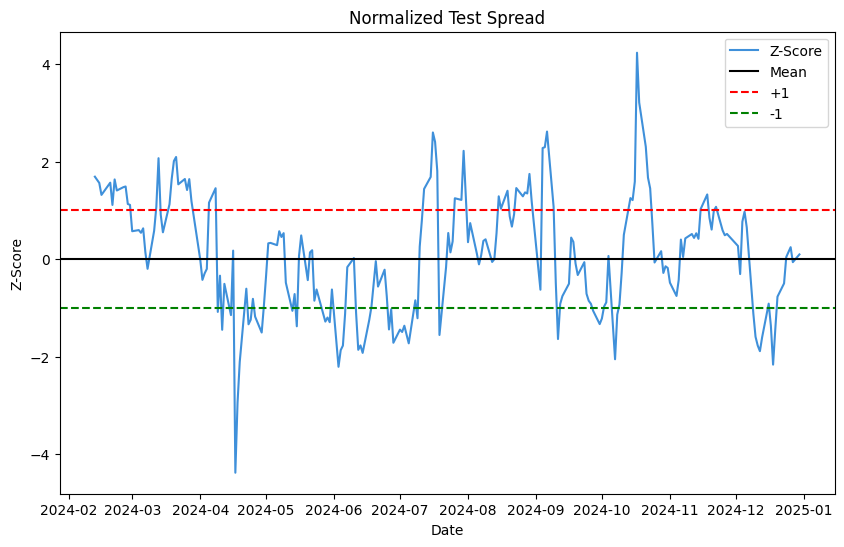

In [22]:
# Normalize test spread and visualize it
test_spread_normalized = (test_spread - test_spread_mean) / test_spread_std

plt.figure(figsize=(10, 6))
plt.plot(test_spread_normalized.index, test_spread_normalized, label='Z-Score')
plt.axhline(0, label='Mean', color='black')
plt.axhline(1, label='+1', color='red', linestyle='--')
plt.axhline(-1, label='-1', color='green', linestyle='--')
plt.title('Normalized Test Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

In [23]:
# Backtest pairs trading strategy
strategy = test_data.copy()
strategy['Z_Score'] = test_spread_normalized
strategy['Hedge_Ratio'] = rolling_hedge_ratios
strategy['Signal'] = 0
strategy['Position'] = 0
strategy.dropna(inplace=True)
cur_position = 0

for t in range(1, len(strategy)):
  # Enter long position if z-score is below -1
  if strategy.iloc[t]['Z_Score'] < -1 and cur_position == 0:
    strategy.loc[strategy.index[t], 'Signal'] = 1
    cur_position = 1
  # Enter short position if z-score is above 1
  elif strategy.iloc[t]['Z_Score'] > 1 and cur_position == 0:
    strategy.loc[strategy.index[t], 'Signal'] = -1
    cur_position = -1
  # Exit long position if z-score crosses back above 0
  elif strategy.iloc[t]['Z_Score'] > 0 and cur_position == 1:
    strategy.loc[strategy.index[t], 'Signal'] = -1
    cur_position = 0
  # Exit short position if z-score crosses back below 0
  elif strategy.iloc[t]['Z_Score'] < 0 and cur_position == -1:
    strategy.loc[strategy.index[t], 'Signal'] = 1
    cur_position = 0

  # Record current position
  strategy.loc[strategy.index[t], 'Position'] = cur_position

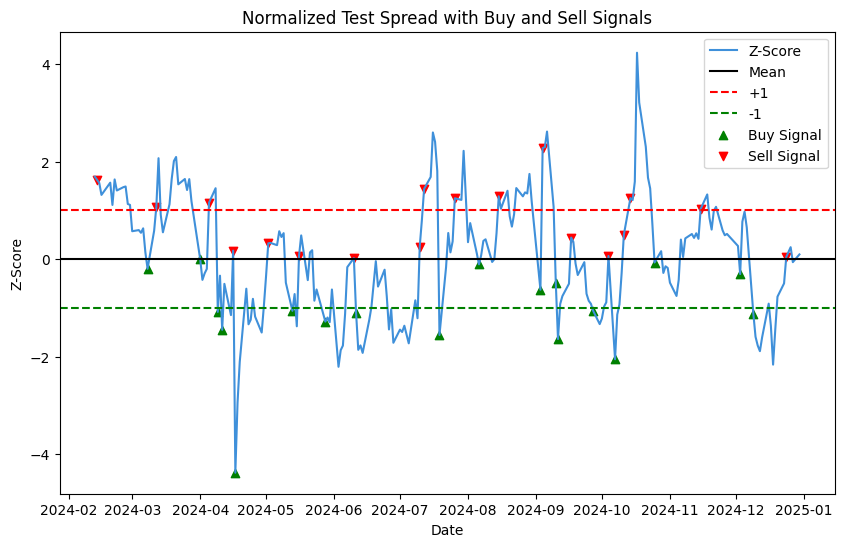

In [25]:
# Plot buy and sell signals
buy_signals = strategy[strategy['Signal'] == 1]
sell_signals = strategy[strategy['Signal'] == -1]

plt.figure(figsize=(10, 6))
plt.plot(test_spread_normalized.index, test_spread_normalized, label='Z-Score')
plt.axhline(0, label='Mean', color='black')
plt.axhline(1, label='+1', color='red', linestyle='--')
plt.axhline(-1, label='-1', color='green', linestyle='--')
plt.scatter(buy_signals.index, buy_signals['Z_Score'], label='Buy Signal', marker='^', color='green')
plt.scatter(sell_signals.index, sell_signals['Z_Score'], label='Sell Signal', marker='v', color='red')
plt.title('Normalized Test Spread with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

Cumulative Return: 2.52


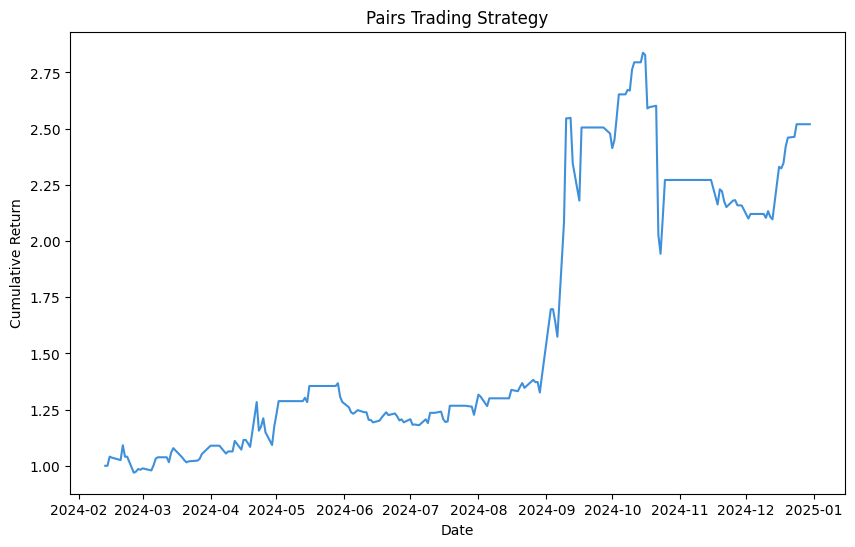

In [26]:
# Calculate and plot cumulative return
strategy[f'{ticker_1}_Return'] = np.log(strategy[ticker_1] / strategy[ticker_1].shift(1))
strategy[f'{ticker_2}_Return'] = np.log(strategy[ticker_2] / strategy[ticker_2].shift(1))
strategy['Spread_Return'] = strategy[f'{ticker_2}_Return'] - strategy['Hedge_Ratio'].shift(1) * strategy[f'{ticker_1}_Return']
strategy['Strategy_Return'] = strategy['Spread_Return'] * strategy['Position'].shift(1)
strategy['Cum_Return'] = strategy['Strategy_Return'].fillna(0).cumsum().apply(np.exp)

print(f'Cumulative Return: {strategy["Cum_Return"].iloc[-1]:.2f}')

plt.figure(figsize=(10,6))
plt.plot(strategy.index, strategy['Cum_Return'])
plt.title('Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [27]:
# Calculate Sharpe ratio
rf_annual = 0.04
num_trading_days = 252
rf_daily = (1 + rf_annual) ** (1 / num_trading_days) - 1

excess_return = strategy['Strategy_Return'] - rf_daily
sharpe_daily = excess_return.mean() / excess_return.std()
sharpe_annual = sharpe_daily * np.sqrt(num_trading_days)

print(f'Sharpe Ratio: {sharpe_annual:.2f}')

Sharpe Ratio: 1.49
